In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


Populating the interactive namespace from numpy and matplotlib


In [2]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [3]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [32]:
import torchvision
import torch
import numpy as np
import os

from torch.utils.data import Dataset, SubsetRandomSampler
from torch.utils.data import DataLoader

from PIL import Image

from tqdm.auto import tqdm

import os.path
from os.path import join

from typing import Optional

from abc import ABC, abstractmethod

import random

from typing import Union
import cv2


# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def get_euler_angles(R):
    sy = torch.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
    singular = sy < 1e-6

    if not singular:
        x = torch.atan2(R[2, 1], R[2, 2])
        y = torch.atan2(-R[2, 0], sy)
        z = torch.atan2(R[1, 0], R[0, 0])
    else:
        x = torch.atan2(-R[1, 2], R[1, 1])
        y = torch.atan2(-R[2, 0], sy)
        z = 0

    return torch.tensor([x, y, z], dtype=x.dtype)

def to_numpy(x):
    x_ = np.array(x)
    x_ = x_.astype(np.float32)
    return x_

def get_image_transform(transform):
    # fix for this issue: https://github.com/pytorch/vision/issues/2194
    if transform is not None and isinstance(transform, torchvision.transforms.Compose) and (transform.transforms[-1], torchvision.transforms.ToTensor):
        transform = torchvision.transforms.Compose([
            *transform.transforms[:-1],
            torchvision.transforms.Lambda(to_numpy),
            torchvision.transforms.ToTensor()
        ])
    elif isinstance(transform, torchvision.transforms.ToTensor):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(to_numpy),
            torchvision.transforms.ToTensor()
        ])

    return transform


def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper:

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References: https://arxiv.org/abs/1606.02147

    Keyword arguments:
    - dataloader (``data.Dataloader``): A data loader to iterate over the
    dataset.
    - num_classes (``int``): The number of classes.
    - c (``int``, optional): AN additional hyper-parameter which restricts
    the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    print("Create class weights...")
    for batch in tqdm(dataloader):
        label = batch[1]
        label = label.cpu().numpy()

        # Flatten label
        flat_label = label.flatten()

        # Sum up the number of pixels of each class and the total pixel
        # counts for each label
        class_count += np.bincount(flat_label, minlength=num_classes)
        total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total

    class_weights = 1 / (np.log(c + propensity_score))

    class_weights[class_count == 0] = 0

    return class_weights


def get_color_encoding(seg_classes):
    if seg_classes.lower() == 'nyu40':
        """Color palette for nyu40 labels """
        return OrderedDict([
            ('void', (0, 0, 0)),
            ('wall', (174, 199, 232)),
            ('floor', (152, 223, 138)),
            ('cabinet', (31, 119, 180)),
            ('bed', (255, 187, 120)),
            ('chair', (188, 189, 34)),
            ('sofa', (140, 86, 75)),
            ('table', (255, 152, 150)),
            ('door', (214, 39, 40)),
            ('window', (197, 176, 213)),
            ('bookshelf', (148, 103, 189)),
            ('picture', (196, 156, 148)),
            ('counter', (23, 190, 207)),
            ('blinds', (178, 76, 76)),
            ('desk', (247, 182, 210)),
            ('shelves', (66, 188, 102)),
            ('curtain', (219, 219, 141)),
            ('dresser', (140, 57, 197)),
            ('pillow', (202, 185, 52)),
            ('mirror', (51, 176, 203)),
            ('floormat', (200, 54, 131)),
            ('clothes', (92, 193, 61)),
            ('ceiling', (78, 71, 183)),
            ('books', (172, 114, 82)),
            ('refrigerator', (255, 127, 14)),
            ('television', (91, 163, 138)),
            ('paper', (153, 98, 156)),
            ('towel', (140, 153, 101)),
            ('showercurtain', (158, 218, 229)),
            ('box', (100, 125, 154)),
            ('whiteboard', (178, 127, 135)),
            ('person', (120, 185, 128)),
            ('nightstand', (146, 111, 194)),
            ('toilet', (44, 160, 44)),
            ('sink', (112, 128, 144)),
            ('lamp', (96, 207, 209)),
            ('bathtub', (227, 119, 194)),
            ('bag', (213, 92, 176)),
            ('otherstructure', (94, 106, 211)),
            ('otherfurniture', (82, 84, 163)),
            ('otherprop', (100, 85, 144)),
        ])
    elif seg_classes.lower() == 'scannet20':
        return OrderedDict([
            ('unlabeled', (0, 0, 0)),
            ('wall', (174, 199, 232)),
            ('floor', (152, 223, 138)),
            ('cabinet', (31, 119, 180)),
            ('bed', (255, 187, 120)),
            ('chair', (188, 189, 34)),
            ('sofa', (140, 86, 75)),
            ('table', (255, 152, 150)),
            ('door', (214, 39, 40)),
            ('window', (197, 176, 213)),
            ('bookshelf', (148, 103, 189)),
            ('picture', (196, 156, 148)),
            ('counter', (23, 190, 207)),
            ('desk', (247, 182, 210)),
            ('curtain', (219, 219, 141)),
            ('refrigerator', (255, 127, 14)),
            ('showercurtain', (158, 218, 229)),
            ('toilet', (44, 160, 44)),
            ('sink', (112, 128, 144)),
            ('bathtub', (227, 119, 194)),
            ('otherfurniture', (82, 84, 163)),
        ])


class Abstract_Dataset(Dataset, ABC):

    def __init__(self,
                 root_path,
                 transform_rgb=None,
                 transform_label=None,
                 transform_uv=None,
                 crop=False,
                 crop_size=(-1, -1),
                 crop_random=True,
                 resize=False,
                 resize_size=(256, 256),
                 create_instance_map=False,
                 load_noise=False,
                 load_uvs=False,
                 load_labels=True,
                 load_instances=True,
                 cache=False,
                 verbose=False):
        # save all constructor arguments
        self.transform_rgb = transform_rgb
        self.transform_label = get_image_transform(transform_label)
        self.transform_uv = transform_uv
        self.crop = crop
        self.crop_size = crop_size
        self.crop_random = crop_random
        self.resize = resize
        self.resize_size = resize_size
        if isinstance(resize_size, int):
            self.resize_size = (resize_size, resize_size)
        if isinstance(crop_size, int):
            self.crop_size = (crop_size, crop_size)
        self.verbose = verbose
        self.root_path = root_path
        self.load_uvs = load_uvs
        self.load_labels = load_labels
        self.load_instances = load_instances
        self.load_noise = load_noise
        self.create_instance_map = create_instance_map
        self.use_cache = cache
        self.cache = {}
        self.label_to_color = list(get_color_encoding("nyu40").items())
        self.label_to_color = list(get_color_encoding("nyu40").items())
        self.num_classes = len(self.label_to_color)

        # create data for this dataset
        self.create_data()

    def create_data(self):
        self.rgb_images, self.label_images, self.instance_images, self.uv_maps, self.extrinsics, self.size, self.scene_dict = self.parse_scenes()

        if self.create_instance_map:
            self.instance_map, self.inverse_instance_map = self.get_instance_map()
        else:
            self.instance_map = None
            self.inverse_instance_map = None

    def get_class_count(self):
        return self.num_classes

    def get_instance_count(self):
        if self.instance_map is None:
            self.instance_map, self.inverse_instance_map = self.get_instance_map()

        return len(self.instance_map.keys())

    def get_instance_map(self):
        instance_map = {}
        inverse_instance_map = {}
        counter = 0
        print("Creating instance map...")
        for i in tqdm(range(self.size)):
            item = self.__getitem__(i)
            instance = item[2]
            instances = [i.detach().cpu().numpy().item() for i in torch.unique(instance)]

            for i in instances:
                if i not in instance_map:
                    instance_map[i] = {
                        "idx": counter,
                        "priority": 1,
                        "name": counter
                    }
                    inverse_instance_map[counter] = {
                        "instance": i,
                        "priority": 1,
                        "name": counter
                    }
                    counter += 1

        return instance_map, inverse_instance_map

    @abstractmethod
    def get_scenes(self):
        """
        Return names to all scenes for the dataset.
        """
        pass

    @abstractmethod
    def get_colors(self, scene_path):
        """
        Return absolute paths to all colors images for the scene (sorted!)
        """
        pass

    @abstractmethod
    def get_labels(self, scene_path):
        """
        Return absolute paths to all label images for the scene (sorted!)
        """
        pass

    @abstractmethod
    def get_instances(self, scene_path):
        """
        Return absolute paths to all instance images for the scene (sorted!)
        """
        pass

    @abstractmethod
    def get_extrinsics(self, scene_path):
        """
        Return absolute paths to all extrinsic images for the scene (sorted!)
        """
        pass

    @abstractmethod
    def get_uvs(self, scene_path):
        """
        Return absolute paths to all uvmap images for the scene (sorted!)
        """
        pass

    def parse_scenes(self):
        rgb_images = []
        label_images = []
        instance_images = []
        uv_maps = []
        extrinsics_matrices = []
        scene_dict = {}

        scenes = self.get_scenes()
        if self.verbose:
            print("Collecting images...")
            scenes = tqdm(scenes)

        for scene in scenes:
            scene_path = join(self.root_path, scene)
            if os.path.isdir(scene_path):
                scene_dict[scene] = {
                    "path": scene_path,
                    "items": 0,
                }

                colors = self.get_colors(scene_path)

                if self.load_labels:
                    labels = self.get_labels(scene_path)
                else:
                    labels = colors

                if self.load_instances:
                    instances = self.get_instances(scene_path)
                else:
                    instances = colors

                extrinsics = self.get_extrinsics(scene_path)

                if self.load_uvs:
                    uvs = self.get_uvs(scene_path)
                else:
                    uvs = []

                if len(colors) > 0 and len(colors) == len(labels) and len(labels) == len(instances) and (
                        len(instances) == len(uvs) or not self.load_uvs) and len(instances) == len(extrinsics):
                    rgb_images.extend(colors)
                    label_images.extend(labels)
                    instance_images.extend(instances)
                    uv_maps.extend(uvs)
                    extrinsics_matrices.extend(extrinsics)
                    scene_dict[scene]["items"] = len(colors)
                    scene_dict[scene]["color"] = colors
                    scene_dict[scene]["label"] = labels
                    scene_dict[scene]["instance"] = instances
                    scene_dict[scene]["extrinsics"] = extrinsics

                    if self.load_uvs:
                        scene_dict[scene]["uv_map"] = uvs
                elif self.verbose:
                    print(f"Scene {scene_path} rendered incomplete --> is skipped. colors: {len(colors)}, labels: {len(labels)}, instances: {len(instances)}, uvs: {len(uvs)}, extr: {len(extrinsics)}")

        assert (len(rgb_images) == len(label_images))
        assert (len(label_images) == len(instance_images))
        assert (len(instance_images) == len(uv_maps) or not self.load_uvs)
        assert (len(instance_images) == len(extrinsics_matrices))

        return rgb_images, label_images, instance_images, uv_maps, extrinsics_matrices, len(rgb_images), scene_dict

    def get_labels_in_image(self, label_image):
        if isinstance(label_image, torch.Tensor):
            label_image = torchvision.transforms.ToPILImage()(label_image.cpu().int())

        if not isinstance(label_image, Image.Image):
            raise ValueError(f"image must be of type {torch.Tensor} or {Image.Image}, but was: {label_image}")

        labels = {}
        for i in range(label_image.size[0]):
            for j in range(label_image.size[1]):
                pixel = label_image.getpixel((i, j))
                if pixel not in labels:
                    # is ordered dict: [pixel] accesses the pixel-th item, [0] accesses the key (which is the label)
                    labels[pixel] = self.label_to_color[pixel][0]

        return labels

    def get_label_masks(self, label_image):
        if isinstance(label_image, torch.Tensor):
            label_image = torchvision.transforms.ToPILImage()(label_image.cpu().int())

        if not isinstance(label_image, Image.Image):
            raise ValueError(f"image must be of type {torch.Tensor} or {Image.Image}, but was: {label_image}")

        masks = {}
        for i in range(label_image.size[0]):
            for j in range(label_image.size[1]):
                pixel = label_image.getpixel((i, j))
                if pixel not in masks:
                    masks[pixel] = np.zeros((label_image.size[1], label_image.size[0]))
                masks[pixel][j, i] = 1

        return masks

    def get_instance_masks(self, instance_image, global_instance_id=True):
        if isinstance(instance_image, torch.Tensor):
            instance_image = torchvision.transforms.ToPILImage()(instance_image.cpu().int())

        if not isinstance(instance_image, Image.Image):
            raise ValueError(f"image must be of type {torch.Tensor} or {Image.Image}, but was: {instance_image}")

        masks = {}
        for i in range(instance_image.size[0]):
            for j in range(instance_image.size[1]):
                pixel = instance_image.getpixel((i, j))

                if global_instance_id:
                    if self.instance_map is None:
                        raise ValueError(f"Cannot use global_instance_id when no instance_map was created!")
                    pixel = self.instance_map[pixel]["global_id"]

                if pixel not in masks:
                    masks[pixel] = np.zeros((instance_image.size[1], instance_image.size[0]))
                masks[pixel][j, i] = 1

        return masks

    def get_color_image(self, label_image):
        if isinstance(label_image, torch.Tensor):
            label_image = torchvision.transforms.ToPILImage()(label_image.cpu().int())

        if not isinstance(label_image, Image.Image):
            raise ValueError(f"image must be of type {torch.Tensor} or {Image.Image}, but was: {label_image}")

        color_image = Image.new("RGB", label_image.size)
        colored_pixels = color_image.load()

        for i in range(color_image.size[0]):
            for j in range(color_image.size[1]):
                pixel = label_image.getpixel((i, j))
                # is ordered dict: [pixel] accesses the pixel-th item, [1] accesses the value (which is the color)
                colored_pixels[i, j] = self.label_to_color[pixel][1]

        return color_image

    def get_nearest_neighbors(self, train_dataset, train_indices, test_indices, n=1, weights=[1.0, 1.0], verbose=False):
        # get all train extrinsics
        train_extrinsics = [train_dataset.__getitem__(i, only_extrinsics=True) for i in train_indices]
        train_r = [get_euler_angles(r) for r in train_extrinsics]
        train_t = [e[:3, 3] for e in train_extrinsics]

        # get all test extrinsics
        test_extrinsics = [self.__getitem__(i, only_extrinsics=True) for i in test_indices]
        test_r = [get_euler_angles(r) for r in test_extrinsics]
        test_t = [e[:3, 3] for e in test_extrinsics]
        test = zip(test_indices, test_r, test_t)
        if verbose:
            print(f"Calculating {n} nearest neighbors for {len(test_indices)} test images within {len(train_indices)} train images")
            test = tqdm(test, total=len(test_indices))

        # dict of lists: i-th entry contains the "n nearest neighbors list" for the test index i
        # an entry in the "n nearest neighbors list" has the form {"i": train_index, "d": distance to test_index}
        neighbors = {i: [] for i in test_indices}

        if n > 0:
            for test_idx, r1, t1 in test:
                for train_idx, r2, t2 in zip(train_indices, train_r, train_t):
                    # calculate distance (weighted between R and T)
                    dr = torch.sum((r2 - r1) ** 2)
                    dt = torch.sum((t2 - t1) ** 2)
                    d = weights[0] * dr + weights[1] * dt

                    # search insertion index
                    insert_index = 0
                    for neighbor in neighbors[test_idx]:
                        if neighbor["d"] > d:
                            break
                        insert_index += 1

                    # only insert if it is one of the n shortest distances
                    if insert_index < n:
                        # add neighbor at the correct index
                        neighbors[test_idx].insert(insert_index, {"i": train_idx, "d": d})

                        # remove neighbors that are no longer among the shortest n
                        neighbors[test_idx] = neighbors[test_idx][:n]

        return neighbors

    @abstractmethod
    def load_extrinsics(self, idx):
        """
        load the extrinsics item from self.extrinsics

        :param idx: the item to load

        :return: the extrinsics as numpy array
        """
        pass

    @abstractmethod
    def load_uvmap(self, idx):
        """
        load the uvmap item from self.uv_maps

        :param idx: the item to load

        :return: the uvmap as PIL image or numpy array
        """
        pass

    @abstractmethod
    def calculate_mask(self, uvmap):
        """
        calculate the uvmap mask item from uvmap (valid values == 1)

        :param idx: the uvmap from which to calculate the mask

        :return: the mask as PIL image
        """
        pass

    def prepare_getitem(self, idx):
        """
        Implementations can prepare anything necessary for loading this idx, i.e. load a .hdf5 file
        :param idx:
        :return:
        """
        pass

    def finalize_getitem(self, idx):
        """
        Implementations can finalize anything necessary after loading this idx, i.e. close a .hdf5 file
        :param idx:
        :return:
        """
        pass

    def load_rgb(self, idx):
        return Image.open(self.rgb_images[idx])

    def load_label(self, idx):
        return Image.open(self.label_images[idx])

    def load_instance(self, idx):
        return Image.open(self.instance_images[idx])

    def __len__(self):
        return self.size

    def __getitem__(self, item, only_extrinsics=False):
        if item not in self.cache:
            self.prepare_getitem(item)

            extrinsics = self.load_extrinsics(item)
            extrinsics = torch.from_numpy(extrinsics)

            if only_extrinsics:
                self.finalize_getitem(item)
                return extrinsics

            rgb = self.load_rgb(item)
            label = self.load_label(item)
            instance = self.load_instance(item)
            uv = None
            mask = None

            if self.load_uvs:
                uv = self.load_uvmap(item)
                mask = self.calculate_mask(uv)
                # resize the rgb, label, instance images to the size of uv to be consistent
                uv_size = np.asarray(uv).shape[:2]
                rgb = torchvision.transforms.Resize(uv_size, interpolation=Image.BICUBIC)(rgb)
                label = torchvision.transforms.Resize(uv_size, interpolation=Image.NEAREST)(label)
                instance = torchvision.transforms.Resize(uv_size, interpolation=Image.NEAREST)(instance)

            if self.crop:
                w, h = rgb.size
                crop_h, crop_w = self.crop_size
                if self.crop_random:
                    # random crop
                    w1 = random.randint(0, w - crop_w)
                    h1 = random.randint(0, h - crop_h)
                else:
                    # center crop
                    w1 = w//2 - crop_w//2
                    h1 = h//2 - crop_h//2

                rgb = rgb.crop((w1, h1, w1 + crop_w, h1 + crop_h))
                label = label.crop((w1, h1, w1 + crop_w, h1 + crop_h))
                instance = instance.crop((w1, h1, w1 + crop_w, h1 + crop_h))

                if self.load_uvs:
                    if isinstance(uv, np.ndarray):
                        uv = uv[h1:h1+crop_h, w1:w1+crop_w,:]
                    else:
                        uv = uv.crop((w1, h1, w1 + crop_w, h1 + crop_h))
                    mask = mask.crop((w1, h1, w1 + crop_w, h1 + crop_h))

            if self.resize and rgb.size != self.resize_size:
                rgb = rgb.resize(self.resize_size)
                label = label.resize(self.resize_size, Image.NEAREST)
                instance = instance.resize(self.resize_size, Image.NEAREST)
                if self.load_uvs:
                    if isinstance(uv, np.ndarray):
                        # PIL library is not able to convert a (W,H,2) image of type np.float32
                        # for this case we use cv2 which can do it
                        uv = cv2.resize(uv, self.resize_size, interpolation=cv2.INTER_NEAREST)
                    else:
                        uv = uv.resize(self.resize_size, Image.NEAREST)
                    mask = mask.resize(self.resize_size, Image.NEAREST)

            if self.transform_rgb:
                rgb = self.transform_rgb(rgb)

            if self.transform_label:
                label = self.transform_label(label)
                instance = self.transform_label(instance)

            if isinstance(label, torch.Tensor):
                label = label.long()

            if isinstance(instance, torch.Tensor):
                instance = instance.long()

            result = (rgb, label, instance, extrinsics, item)

            if self.load_uvs and self.transform_uv:
                uv = self.transform_uv(uv)
                mask = np.array(mask)
                mask = self.transform_uv(mask)
                mask = mask > -1
                mask = mask.squeeze()  # Final shape: H x W
                result += (uv, mask)

            if self.use_cache:
                self.cache[item] = result

            self.finalize_getitem(item)

            return result
        else:
            return self.cache[item]


In [33]:
# taken from: https://github.com/krrish94/ENet-ScanNet/blob/master/data/scannet.py

import os
import numpy as np
import torchvision
from PIL import Image
from os.path import join


class ScanNetDataset(Abstract_Dataset):

    orig_sizes = {
        # in format (h, w)
        "rgb": (240, 320),
        "label": (240, 320),
        "uv": (480, 640)
    }

    def __init__(self,
                 root_path,
                 transform_rgb=None,
                 transform_label=None,
                 transform_uv=None,
                 crop=False,
                 crop_size=(-1, -1),
                 crop_random=True,
                 resize=False,
                 resize_size=(256, 256),
                 create_instance_map=False,
                 load_noise=False,
                 load_uvs=False,
                 load_stylized_images=False,
                 cache=False,
                 verbose=False):

        self.set_stylized_image_mode(load_stylized_images)

        Abstract_Dataset.__init__(self,
                                  root_path=root_path,
                                  transform_rgb=transform_rgb,
                                  transform_label=transform_label,
                                  transform_uv=transform_uv,
                                  crop=crop,
                                  crop_size=crop_size,
                                  crop_random=crop_random,
                                  resize=resize,
                                  resize_size=resize_size,
                                  load_noise=load_noise,
                                  create_instance_map=create_instance_map,
                                  load_uvs=load_uvs,
                                  cache=cache,
                                  verbose=verbose)

    def set_stylized_image_mode(self, stylized_images: bool):
        self.stylized_images = stylized_images

    def get_scenes(self):
        return os.listdir(self.root_path)

    def get_colors(self, scene_path):
        """
        Return absolute paths to all colors images for the scene (sorted!)
        """
        if not self.stylized_images:
            color_path = join(scene_path, "color")
        else:
            color_path = join(scene_path, "stylized_color")
        if not os.path.exists(color_path) or not os.path.isdir(color_path):
            return []

        colors = sorted(os.listdir(color_path), key=lambda x: int(x.split(".")[0]))
        colors = [join(color_path, f) for f in colors]

        return colors

    def get_labels(self, scene_path):
        """
        Return absolute paths to all label images for the scene (sorted!)
        """
        label_path = join(scene_path, "label")

        if not os.path.exists(label_path) or not os.path.isdir(label_path):
            return []

        labels = sorted(os.listdir(label_path), key=lambda x: int(x.split(".")[0]))
        labels = [join(label_path, f) for f in labels]

        return labels

    def get_instances(self, scene_path):
        """
        Return absolute paths to all instance images for the scene (sorted!)
        """
        instance_path = join(scene_path, "instance")

        if not os.path.exists(instance_path) or not os.path.isdir(instance_path):
            return []

        instances = sorted(os.listdir(instance_path), key=lambda x: int(x.split(".")[0]))
        instances = [join(instance_path, f) for f in instances]

        return instances

    def get_extrinsics(self, scene_path):
        """
        Return absolute paths to all extrinsic images for the scene (sorted!)
        """
        if self.load_noise:
            extrinsics_path = join(scene_path, "pose_noise")
        else:
            extrinsics_path = join(scene_path, "pose")

        if not os.path.exists(extrinsics_path) or not os.path.isdir(extrinsics_path):
            return []

        extrinsics = sorted(os.listdir(extrinsics_path), key=lambda x: int(x.split(".")[0]))
        extrinsics = [join(extrinsics_path, f) for f in extrinsics]

        return extrinsics

    def get_uvs(self, scene_path):
        """
        Return absolute paths to all uvmap images for the scene (sorted!)
        """
        if self.load_noise:
            uv_path = join(scene_path, "uv_noise")
        else:
            uv_path = join(scene_path, "uv")

        if not os.path.exists(uv_path) or not os.path.isdir(uv_path):
            return []

        uvs = sorted(os.listdir(uv_path), key=lambda x: int(x.split(".")[0]))
        uvs_npy = [join(uv_path, f) for f in uvs if "npy" in f]
        uvs_png = [join(uv_path, f) for f in uvs if "png" in f]

        if len(uvs_npy) >= len(uvs_png):
            self.uv_npy = True
            return uvs_npy
        else:
            self.uv_npy = False
            return uvs_png

    def load_extrinsics(self, idx):
        """
        load the extrinsics item from self.extrinsics

        :param idx: the item to load

        :return: the extrinsics as numpy array
        """

        extrinsics = open(self.extrinsics[idx], "r").readlines()
        extrinsics = [[float(item) for item in line.split(" ")] for line in extrinsics]
        extrinsics = np.array(extrinsics, dtype=np.float32)

        return extrinsics

    def load_uvmap(self, idx):
        """
        load the uvmap item from self.uv_maps

        :param idx: the item to load

        :return: the uvmap as PIL image or numpy array
        """

        file = self.uv_maps[idx]
        if self.uv_npy:
            return np.load(file)
        else:
            return Image.open(file)

    def calculate_mask(self, uvmap):
        """
        calculate the uvmap mask item from uvmap (valid values == 1)

        :param idx: the uvmap from which to calculate the mask

        :return: the mask as PIL image
        """

        mask = np.asarray(uvmap)
        if self.uv_npy:
            mask_bool = mask[:, :, 0] != 0
            mask_bool += mask[:, :, 1] != 0
            mask = mask_bool
        else:
            mask = mask[:, :, 2] == 0
        mask = Image.fromarray(mask)

        return mask
    
    
import numpy as np

from PIL import Image
from os.path import join
from tqdm.auto import tqdm

import torch
import torchvision


class ScanNet_Single_House_Dataset(ScanNetDataset):

    def __init__(self,
                 root_path,
                 scene=None,
                 min_images=1000,
                 max_images=-1,
                 transform_rgb=None,
                 transform_label=None,
                 transform_uv=None,
                 crop=False,
                 crop_size=(-1,-1),
                 crop_random=True,
                 resize=False,
                 resize_size=(256, 256),
                 load_noise=False,
                 load_uvs=False,
                 load_stylized_images=False,
                 create_instance_map=False,
                 cache=False,
                 verbose=False):

        self.input_scene = scene
        self.min_images = min_images
        self.max_images = max_images
        self.create_instance_map = create_instance_map

        ScanNetDataset.__init__(self,
                                root_path=root_path,
                                transform_rgb=transform_rgb,
                                transform_label=transform_label,
                                transform_uv=transform_uv,
                                crop=crop,
                                crop_size=crop_size,
                                crop_random=crop_random,
                                resize=resize,
                                resize_size=resize_size,
                                load_uvs=load_uvs,
                                load_noise=load_noise,
                                load_stylized_images=load_stylized_images,
                                create_instance_map=False,  # only create it afterwards when needed because we shrinken scenes anyways after this
                                cache=cache,
                                verbose=verbose)

    def create_data(self):
        self.scene_dict = self.parse_scenes()[-1]
        self.rgb_images, self.label_images, self.instance_images, self.extrinsics, self.uv_maps, self.size, self.scene = self.get_scene(self.input_scene, self.min_images, self.max_images)

        print(f"Using scene: {self.scene}. Input was: {self.input_scene}")

        if self.create_instance_map:
            self.instance_map, self.inverse_instance_map = self.get_instance_map()
        else:
            self.instance_map = None
            self.inverse_instance_map = None

    def get_scene(self, scene, min_images, max_images):
        items = self.get_scene_items(scene)
        if self.in_range(min_images, max_images, items):
            return self.parse_scene(scene)
        else:
            return self.find_house(min_images, max_images)

    def get_scene_items(self, scene):
        if scene is None:
            return None
        elif scene not in self.scene_dict:
            return 0
        else:
            return self.scene_dict[scene]["items"]

    def in_range(self, min, max, value):
        return (value is not None) and (min == -1 or value >= min) and (max == -1 or value <= max)

    def parse_scene(self, scene):
        h = self.scene_dict[scene]
        if self.load_uvs:
            return h["color"], h["label"], h["instance"], h["extrinsics"], h["uv_map"], len(h["color"]), scene
        else:
            return h["color"], h["label"], h["instance"], h["extrinsics"], [], len(h["color"]), scene

    def find_house(self, min_images, max_images):
        max = -1
        min = -1
        scenes = self.scene_dict
        if self.verbose:
            scenes = tqdm(scenes)
            print(f"Searching for a house with more than {min_images} images")
        for h in scenes:
            size = self.get_scene_items(h)
            if max == -1 or size > max:
                max = size
            if min == -1 or size < min:
                min = size
            if self.in_range(min_images, max_images, size):
                if self.verbose:
                    print(f"Using scene '{h}' which has {size} images")
                return self.parse_scene(h)
        raise ValueError(f"No scene found with {min_images} <= i <= {max_images} images. Min/Max available: {min}/{max}")

In [186]:
# pre and post processing for images
img_size = 256 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                           transforms.Lambda(lambda x: x.cuda() if torch.cuda.is_available() else x)
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.cpu() if torch.cuda.is_available() else x),
                            transforms.Lambda(lambda x: x.mul_(1./255)),
                            transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                 std=[1,1,1]),
                             transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    #t = tensor
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [187]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [188]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', '0.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

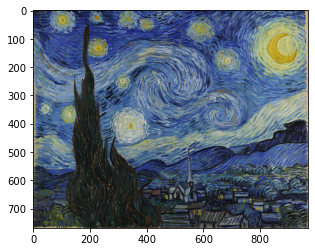

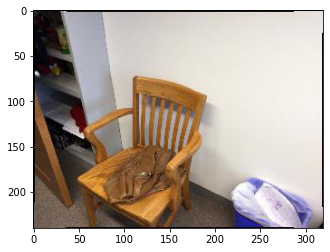

In [189]:
#display images
for img in imgs:
    imshow(img);show()

In [207]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2

# load single uv
uv = np.load(image_dir + "0.npy")
uv_transform = transforms.Compose([
    transforms.Lambda(lambda x: x * 2.0 - 1.0),
    transforms.Lambda(lambda x: cv2.resize(x, (341,256), interpolation=cv2.INTER_NEAREST)),
    transforms.Lambda(lambda x: x[np.newaxis,...]),
    transforms.Lambda(lambda x: torch.from_numpy(x)),
    transforms.Lambda(lambda x: x.cuda() if torch.cuda.is_available() else x)
])
uv = uv_transform(uv)
print(uv.shape)
print(uv.dtype)
print(torch.min(uv), torch.max(uv))

# init texture
class NeuralTexture(nn.Module):
    def __init__(self, W, H, C, random_init=False):
        super(NeuralTexture, self).__init__()
        self.W = W
        self.H = H
        self.C = C

        if random_init:
            self.data = torch.nn.Parameter(torch.rand(C, H, W, requires_grad=True), requires_grad=True)
        else:
            self.data = torch.nn.Parameter(torch.zeros(C, H, W, requires_grad=True), requires_grad=True)

    def forward(self, x):
        batch_size = x.shape[0]
        y = F.grid_sample(self.data.repeat(batch_size, 1, 1, 1),
                          x,
                          mode='bilinear',
                          padding_mode='border',
                          align_corners=True) # this treats (0,0) as origin and not as the center of the lower left texel

        return y
    
    def get_image(self):
        return self.data

    def save_image(self, dir, prefix=""):
        image = to_image(self.get_image().detach().cpu())
        file_path = join(dir, f"{prefix}texture.jpg")
        image.save(file_path)

    def save_texture(self, dir, prefix=""):
        image = self.data.detach().cpu()
        file_path = join(dir, f"{prefix}texture.pt")
        torch.save(image, file_path)
        
class HierarchicalNeuralTexture(nn.Module):
    def __init__(self, W, H, C, num_layers=4, random_init=False):
        super(HierarchicalNeuralTexture, self).__init__()
        self.W = W
        self.H = H
        self.C = C

        # laplacian pyramid, i.e. first layer is (W, H), second is (W//2, H//2), third is (W//4, H//4), ...
        self.layers = nn.ModuleList([NeuralTexture(W // pow(2, i), H // pow(2, i), C, random_init) for i in range(num_layers)])

    def forward(self, x):
        y = [layer(x) for layer in self.layers]
        y = torch.stack(y)
        y = torch.sum(y, dim=0)
        return y

    def get_image(self):
        w_range = torch.arange(0, self.W, dtype=torch.float) / (self.W - 1.0) * 2.0 - 1.0
        h_range = torch.arange(0, self.H, dtype=torch.float) / (self.H - 1.0) * 2.0 - 1.0

        v, u = torch.meshgrid(h_range, w_range)
        uv_id = torch.stack([u, v], 2)
        uv_id = uv_id.unsqueeze(0)
        uv_id = uv_id.type_as(self.layers[0].data)

        texture = self.forward(uv_id)[0, 0:3, :, :]

        return texture

    def save_image(self, dir, prefix=""):
        texture = self.get_image()
        texture = to_image(texture.detach().cpu())
        file_path = join(dir, f"{prefix}texture.jpg")
        texture.save(file_path)

    def save_texture(self, dir, prefix=""):
        for i, l in enumerate(self.layers):
            l.save_texture(dir, f"{prefix}layer-{i}-")

texture = HierarchicalNeuralTexture(content_image.shape[-1], content_image.shape[-2], 3)

# cuda
if torch.cuda.is_available():
    uv = uv.cuda()
    texture = texture.cuda()

torch.Size([1, 256, 341, 2])
torch.float32
tensor(-1., device='cuda:0') tensor(0.9999, device='cuda:0')


In [208]:
# load dataset
d = ScanNet_Single_House_Dataset(root_path="/home/lukas/datasets/ScanNet/train/images",
                                 scene="scene0230_00",
                              verbose=True,
                              transform_rgb=prep,
                              transform_label=None,
                              transform_uv=uv_transform,
                              load_uvs=True,
                              create_instance_map=False,
                              crop=False,
                              crop_size=256,
                              max_images=500,
                              min_images=100)

print(d.size)


Using scene: scene0230_00. Input was: scene0230_00
160


ITEM:  0


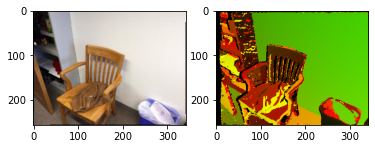

ITEM:  1


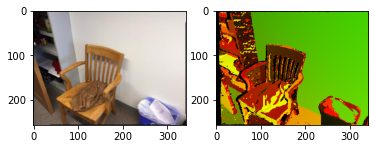

ITEM:  2


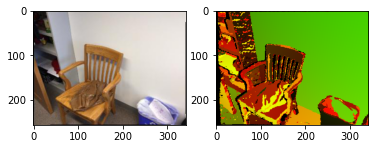

ITEM:  3


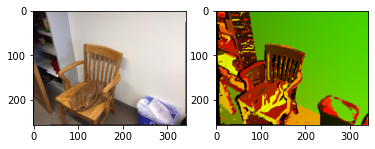

In [209]:
for idx, (rgb, _, _, _, _, uvs, _) in enumerate(d):
    print("ITEM: ", idx)
    
    # convert uv back to [0,1] and add a third dimension again
    uvs = uvs.cpu()
    uvs = uvs.squeeze()
    uvs = (uvs + 1) / 2.0
    b_channel = torch.zeros_like(uvs[:,:,0]).unsqueeze(2)
    uvs = torch.cat((uvs, b_channel), dim=2)
    uvs = uvs.permute(2,0,1)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(postp(rgb))
    ax[1].imshow(torchvision.transforms.ToPILImage()(uvs))
    plt.show()
    
    if idx > 2:
        break

In [210]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

0
Iteration: 50, loss: 114256032.000000
1
Iteration: 100, loss: 8183893.000000
Iteration: 150, loss: 3728304.250000
2
Iteration: 200, loss: 4899816.500000
Iteration: 250, loss: 2550819.500000
Iteration: 300, loss: 2268404.500000
3
Iteration: 350, loss: 2483724.000000
Iteration: 400, loss: 2039350.375000
4
Iteration: 450, loss: 3003259.750000
Iteration: 500, loss: 1895177.500000
Iteration: 550, loss: 1687041.125000
5
Iteration: 600, loss: 2023966.500000
Iteration: 650, loss: 1692431.250000
6
Iteration: 700, loss: 2213055.000000
Iteration: 750, loss: 1607916.750000
7
Iteration: 800, loss: 2726247.750000
Iteration: 850, loss: 1684598.750000
Iteration: 900, loss: 1517983.750000
8
Iteration: 950, loss: 1837232.000000
Iteration: 1000, loss: 1653672.250000
9
Iteration: 1050, loss: 2572415.250000
Iteration: 1100, loss: 1510187.500000
Iteration: 1150, loss: 1412247.000000


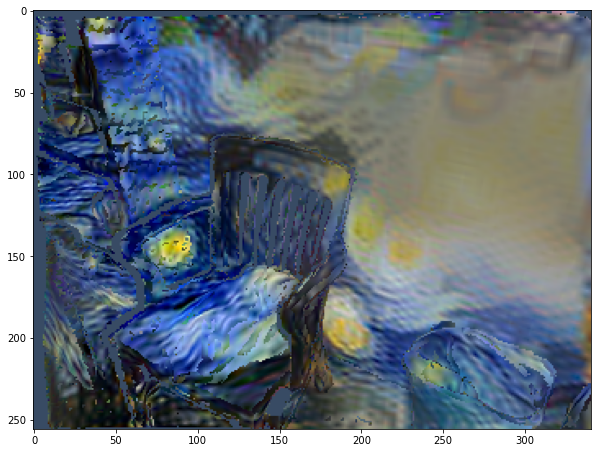

In [211]:
#run style transfer
max_iter = 100000
max_epochs = 10
max_items_per_epoch = 5
show_iter = 50
#optimizer = optim.LBFGS([opt_img]);
optimizer = optim.LBFGS(texture.parameters());
#optimizer = optim.Adam(texture.parameters(), lr=1)
#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda x: 0.1)
n_iter=[0]
n_epochs=[0]

while n_epochs[0] < max_epochs:
    print(n_epochs[0])
    for idx, (rgb, _, _, _, _, uv, _) in enumerate(d):

        def closure():
            optimizer.zero_grad()
            #out = vgg(opt_img, loss_layers)
            out = vgg(texture(uv), loss_layers)
            content_targets = [A.detach() for A in vgg(rgb.unsqueeze(0), content_layers)]
            targets = style_targets + content_targets
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            n_iter[0]+=1
            #print loss
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
    #             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
            return loss

        optimizer.step(closure)
        
        if n_iter[0] > max_iter:
            break
        if idx >= max_items_per_epoch:
            break
    n_epochs[0]+=1
    #scheduler.step()
    
#display result
#out_img = postp(opt_img.data[0].cpu().squeeze())
out_img = postp(texture(uv)[0].cpu())
imshow(out_img)
gcf().set_size_inches(10,10)

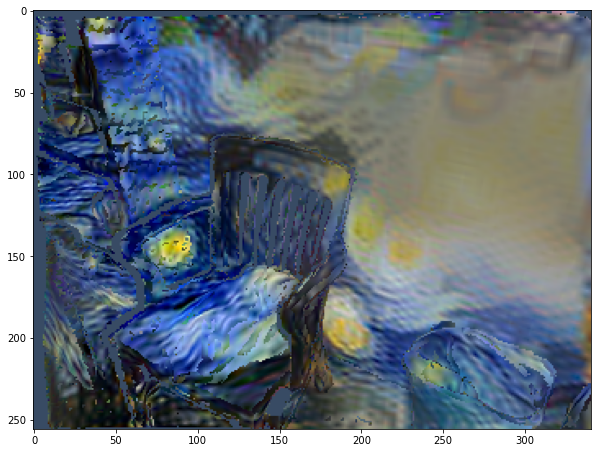

In [212]:
out_img = postp(texture(uv)[0].cpu())
imshow(out_img)
gcf().set_size_inches(10,10)

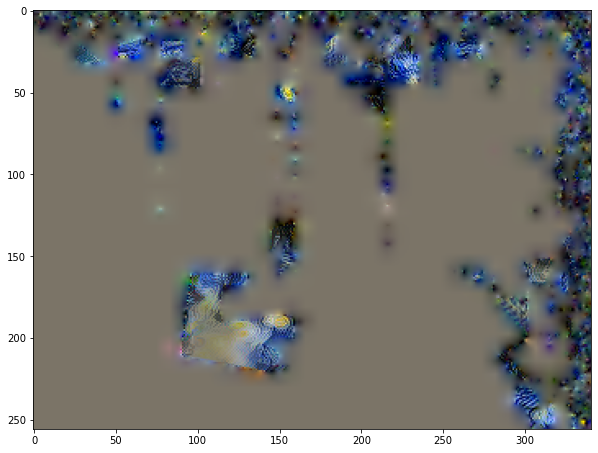

In [213]:
out_img = postp(texture.get_image().cpu())
imshow(out_img)
gcf().set_size_inches(10,10)

texture_img = texture.get_image().cpu()
texture_img = postp(texture_img)
texture_img.save("/home/lukas/Desktop/texture.jpg")

In [10]:
#make the image high-resolution as described in 
#"Controlling Perceptual Factors in Neural Style Transfer", Gatys et al. 
#(https://arxiv.org/abs/1611.07865)

#hr preprocessing
img_size_hr = 800 #works for 8GB GPU, make larger if you have 12GB or more
prep_hr = transforms.Compose([transforms.Scale(img_size_hr),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
#prep hr images
imgs_torch = [prep_hr(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

#now initialise with upsampled lowres result
opt_img = prep_hr(out_img).unsqueeze(0)
opt_img = Variable(opt_img.type_as(content_image.data), requires_grad=True)

#compute hr targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

Iteration: 50, loss: 393681.656250
Iteration: 100, loss: 318565.343750
Iteration: 150, loss: 288719.718750
Iteration: 200, loss: 272176.625000


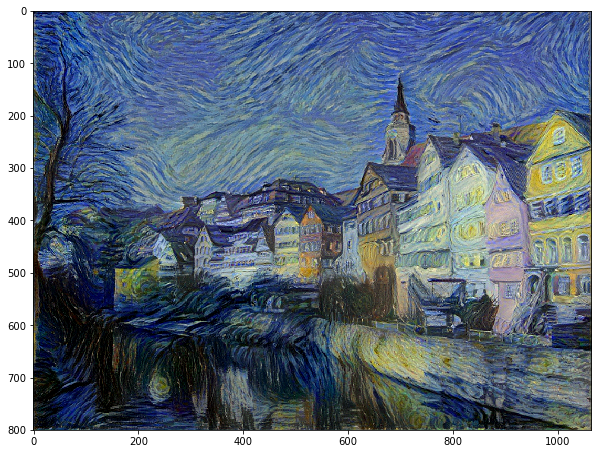

In [11]:
#run style transfer for high res 
max_iter_hr = 200
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]
while n_iter[0] <= max_iter_hr:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img_hr = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img_hr)
gcf().set_size_inches(10,10)